In [1]:
import pytest
import numpy as np
from matplotlib import pyplot as plt

from conservative_nn.time_integrator import RK4Integrator
from conservative_nn.nn_models import SingleParticleNNLagrangian, LagrangianModel
from conservative_nn.dynamical_system import KeplerSystem
from conservative_nn.trajectories import (
    TrajectoryGenerator,
    PositionMonitor,
    InvariantMonitor,
    SingleParticleInvariantMonitor
)
from conservative_nn.initializer import KeplerInitializer
from conservative_nn.kepler import KeplerSolution


%matplotlib inline
%load_ext autoreload
%autoreload 2


ModuleNotFoundError: No module named 'conservative_nn.matplotlib'

## Load models from disk and run trajectory generators

In [9]:
dt = 0.01
# final time
t_final = 128.0
dim = 3
# Dynamical system for exact integration

mass = 1.0
alpha = 1.0
excentricity = 0.8
energy = -0.1

kepler_solution = KeplerSolution(
    mass=mass,
    alpha=alpha,
    excentricity=excentricity,
    energy=energy,
)
initializer = KeplerInitializer(kepler_solution)
perturbed_initializer = KeplerInitializer(kepler_solution,perturbation=0.05)

dynamical_system = KeplerSystem(mass, alpha)

monitors = {}
monitors_nn = {}
monitors_nn_perturbed = {}

for model_label in ["","rot"]:
    # load Lagrangian from disk
    filetag = "_" if model_label == "" else "_"+model_label+"_"
    model_filename = f"assets/trained_models/kepler/nn_lagrangian{filetag}5Aug2022/"
    nn_lagrangian = SingleParticleNNLagrangian.from_saved_model(model_filename)
    model = LagrangianModel(nn_lagrangian)
    # Monitors
    monitors[model_label] = [PositionMonitor(dim)]
    monitors_nn[model_label] = [PositionMonitor(dim),
                                InvariantMonitor(nn_lagrangian),
                                SingleParticleInvariantMonitor(dynamical_system)]
    monitors_nn_perturbed[model_label] = [PositionMonitor(dim)]

    # Run trajectory generators
    trajectory_generator = TrajectoryGenerator(dynamical_system,
                                               initializer,
                                               monitors[model_label],
                                               dt=dt,t_final=t_final)
    trajectory_generator_nn = TrajectoryGenerator(model,
                                                  initializer,
                                                  monitors_nn[model_label],
                                                  dt=dt,t_final=t_final)
    trajectory_generator_nn_perturbed = TrajectoryGenerator(model,
                                                            perturbed_initializer,
                                                            monitors_nn_perturbed[model_label],
                                                            dt=dt,t_final=t_final)
    trajectory_generator.run()
    trajectory_generator_nn.run()
    trajectory_generator_nn_perturbed.run()
    T = trajectory_generator.t

## Plot (projection of) trajectories

(3, 12801)
(3, 12801)


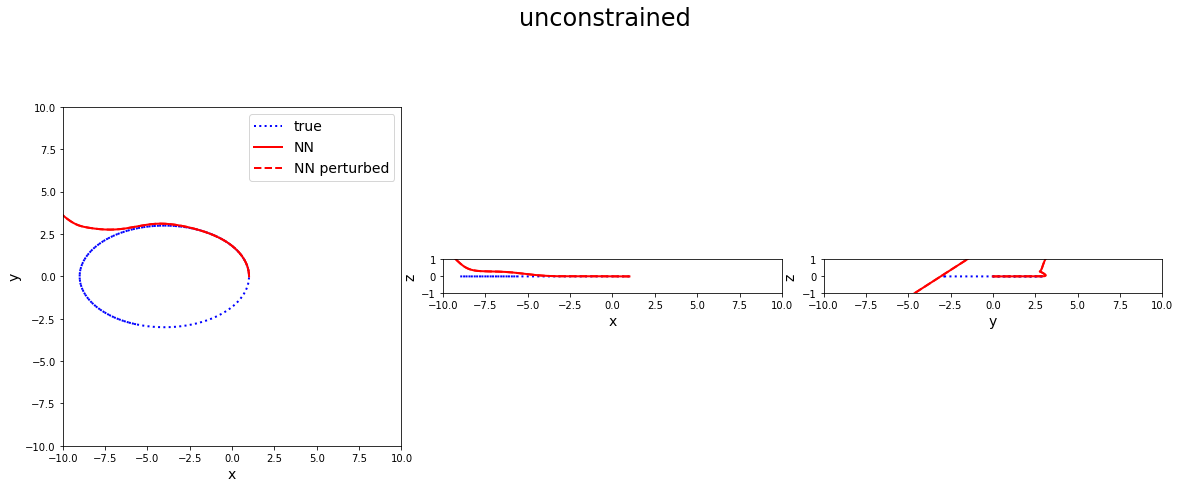

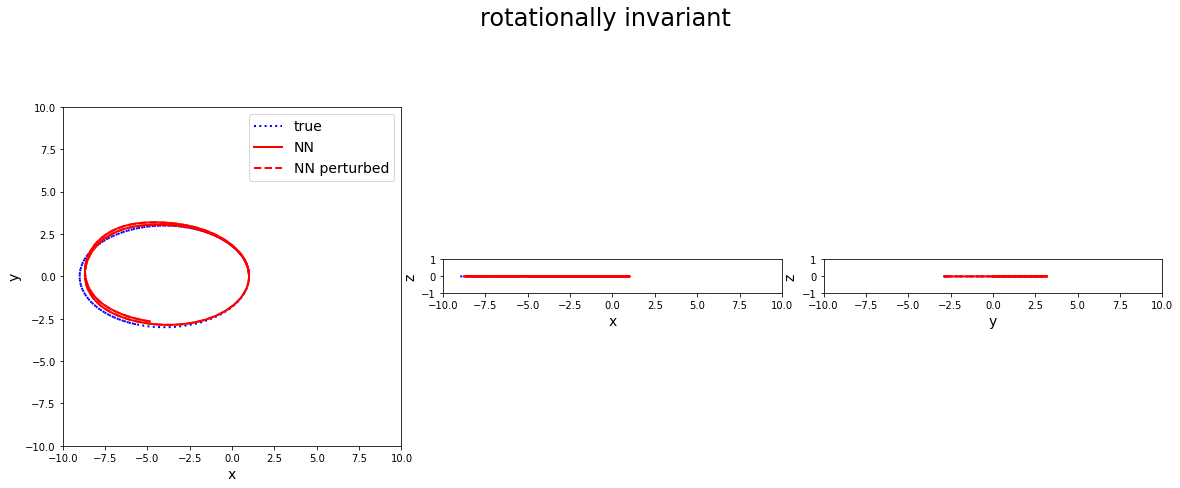

In [11]:
title = {"":"unconstrained","rot":"rotationally invariant"}

for model_label in ["","rot"]:
    # Indices of space dimensions for projection
    fig, axs = plt.subplots(1,3,figsize=(16,8))
    fig.tight_layout()
    q_all = monitors[model_label][0].value
    q_all_nn = monitors_nn[model_label][0].value
    q_all_nn_perturbed = monitors_nn[model_label][0].value
    print (q_all.shape)
    idx = [[0,1],[0,2],[1,2]]
    labels = "xyz"
    Phi = np.arange(-np.pi,+np.pi,1.E-3)
    p_exact = kepler_solution.position(Phi)
    Phi_random = np.random.uniform(low=-np.pi, high=+np.pi,size=[100])
    p_exact_random = kepler_solution.position(Phi_random)
    for j in range(3):
        axs[j].set_xlim(-10,+10)
        if j==0:
            axs[j].set_ylim(-10,+10)
        else:
            axs[j].set_ylim(-1,+1)
        axs[j].set_aspect(1)
        axs[j].plot(q_all[idx[j][0],:],q_all[idx[j][1],:],
                    linewidth=2,linestyle=":",color="blue",
                    label="true")
        axs[j].plot(q_all_nn[idx[j][0],:],q_all_nn[idx[j][1],:],
                    linewidth=2,color="red",
                    label="NN")
        axs[j].plot(q_all_nn_perturbed[idx[j][0],:],
                    q_all_nn_perturbed[idx[j][1],:],linewidth=2,color="red",linestyle="--",
                    label="NN perturbed")
        #axs[j].plot(p_exact[idx[j][0],:],p_exact[idx[j][1],:],
        #            linewidth=2,linestyle=":",color="black",
        #            label="analytical")
        if j==0:
            axs[j].legend(loc="upper right",fontsize=14)
        axs[j].set_xlabel(labels[idx[j][0]],fontsize=14)
        axs[j].set_ylabel(labels[idx[j][1]],fontsize=14)
    fig.suptitle(title[model_label],fontsize=24)


## Plot invariants

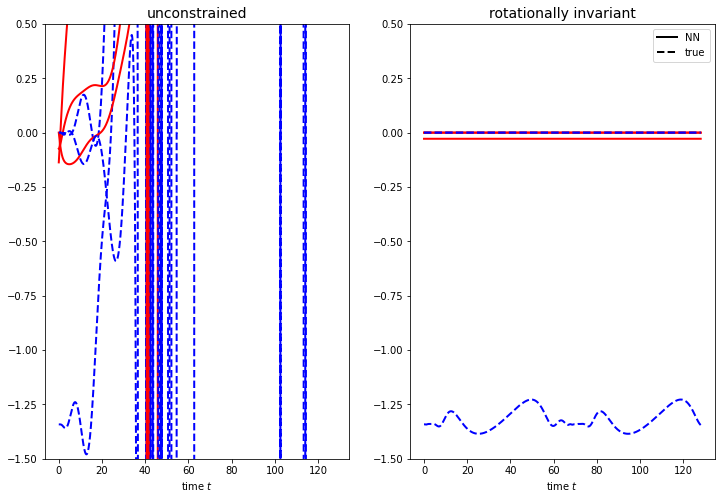

In [12]:
model_label_list = ["","rot"]

title = {"":"unconstrained",
         "rot":"rotationally invariant"}

fig, axs = plt.subplots(1, 2, figsize=(12,8))
for row in [0,1]:
    model_label = model_label_list[row]
    invariant = monitors_nn[model_label][1].value
    invariant_true = monitors_nn[model_label][2].value
    ax = axs[row]
    # Plot angular momentum
    for j in range(dim*(dim-1)//2):
        ax.plot(trajectory_generator_nn.t,invariant[j],linewidth=2,color="red")
        ax.plot(trajectory_generator_nn.t,invariant_true[j],linewidth=2,linestyle="--",color="blue")
    if row==1:
        ax.plot([],[],linewidth=2,color="black",label="NN")
        ax.plot([],[],linewidth=2,color="black",linestyle="--",label="true")
        ax.legend(loc="upper right")
    ax.set_xlabel("time $t$")
    ax.set_ylim(-1.5,+0.5)
    ax.set_title(title[model_label],fontsize=14)

plt.show()


## Plot deviation between NN and true trajectories

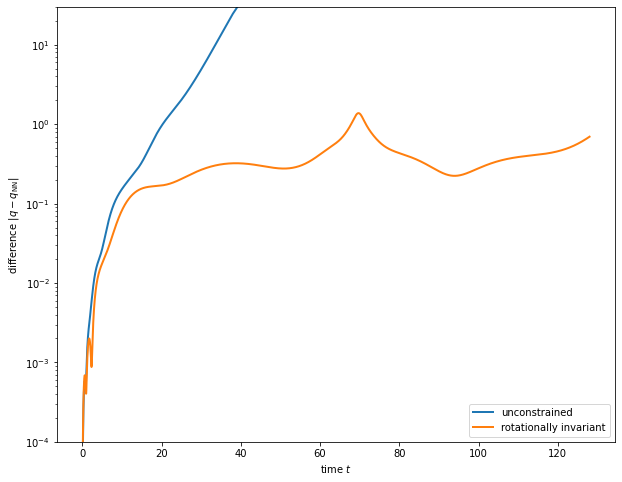

In [14]:
model_label_list = ["","rot"]

label = {"":"unconstrained",
         "rot":"rotationally invariant"}

plt.figure(figsize=(10,8))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-4,30)
for model_label in model_label_list:
    q_all = monitors[model_label][0].value
    q_all_nn = monitors_nn[model_label][0].value
    dq = np.linalg.norm(q_all_nn[:,:]-q_all[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,label=label[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel(r"difference $|q-q_{\operatorname{NN}}|$")
plt.legend(loc="lower right")
plt.show()

## Plot deviation between unperturbed and perturbed trajectories

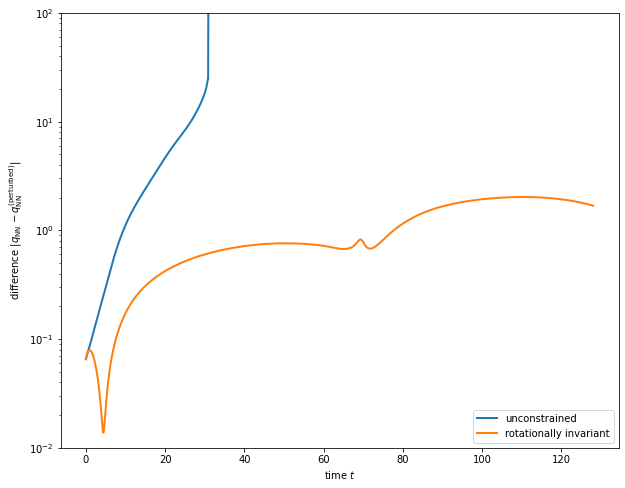

In [16]:
model_label_list = ["","rot"]

label = {"":"unconstrained",
         "rot":"rotationally invariant"}

plt.figure(figsize=(10,8))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-2,100)
for model_label in model_label_list:
    q_all_nn = monitors_nn[model_label][0].value
    q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].value
    dq = np.linalg.norm(q_all_nn[:,:]-q_all_nn_perturbed[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,label=label[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel(r"difference $|q_{\operatorname{NN}}-q^{(\operatorname{perturbed})}_{\operatorname{NN}}|$")
plt.legend(loc="lower right")
plt.show()